# 第四章 量子算法（Quantum Algorithm）


在第三章可逆计算里，给定$f(x)$，我们可以通过构造与辅助比特没有纠缠的可逆电路，从而系统地构造对应的量子电路。这样当输入态是$\frac{1}{2^{n/2}}\sum_{x= 0}^{2^n-1}|x\rangle$时，我们似乎可以“并行”运算$2^n$个输入的值$x$。但是由于测量的过程会随机塌缩到某一个输出态，例如$f(x_k)$，我们并不能真正同时得到所有的计算结果。因此，为了真正利用量子并行性，我们需要非常巧妙的算法设计来提取有用的计算结果，起到加速的效果。本节尽量以直观的方式介绍一些简单的算法框架。



In [8]:
import numpy as np
import itertools
import tensorcircuit as tc

## 1. Dense Coding 算法

我们先看一个利用量子力学性质实现的量子通讯里的巧妙协议，在这一算法中，Alice 和 Bob 相处两地，但利用量子纠缠的特性，Alice 可以通过发送给 Bob 一个量子比特（量子态）来传递两个经典比特的信息。

Alice 首先将 EPR 纠缠对中的一个粒子发送给 Bob。此时 Alice 对自己的粒子做 I，X，Y，Z 操作中的一个。则相应的原始的 $\vert 00\rangle + \vert 11\rangle$ 的态对应转化为 $\vert 00\rangle + \vert 11\rangle$, $\vert 10\rangle + \vert 01\rangle$, $\vert 10\rangle - \vert 01\rangle$，$\vert 00\rangle - \vert 11\rangle$。操作后， Alice 将该粒子也发送给 Bob。注意到此过程，只传递了一个 qubit（第一次的准备工作不算，可以理解为初始 Alice Bob 即共享一个纠缠对）。而 Bob 最后收到全部两个粒子后，可以进行 Bell 基测量，从而知道对应的态，也即 Alice 的 I，X，Y，Z 信息，恰好为两个经典比特。由此实现了用一个 qubit 进行两个经典 bit 的密集编码。整个过程对应的线路图如下：


<div align = center>
<img src="./img/densecoding.png" width="750"  />
<figcaption align = "center">密集编码算法示意图 </figcaption>
</div>

In [21]:
def dense_coding(b1, b2):
    c = tc.Circuit(2)

    # EPR pair preparation

    c.h(0)
    c.cnot(0, 1)

    # information encoding

    if b1 == 1:
        c.z(0)
    if b2 == 1:
        c.x(0)

    # Bell basis measurement

    c.cnot(0, 1)
    c.h(0)

    r1 = c.measure(0)
    r2 = c.measure(1)

    return r1, r2


dense_coding(0, 0), dense_coding(0, 1), dense_coding(1, 0), dense_coding(1, 1)

(((array([0.], dtype=float32), -1.0), (array([0.], dtype=float32), -1.0)),
 ((array([0.], dtype=float32), -1.0), (array([1.], dtype=float32), -1.0)),
 ((array([1.], dtype=float32), -1.0), (array([0.], dtype=float32), -1.0)),
 ((array([1.], dtype=float32), -1.0), (array([1.], dtype=float32), -1.0)))

In [25]:
# 扩展：我们也可以实现上述方案的可即时编译版本

with tc.runtime_backend("tensorflow") as K:

    @K.jit
    def dense_coding_jittable(b1, b2):
        c = tc.Circuit(2)

        # EPR pair preparation

        c.h(0)
        c.cnot(0, 1)

        # information encoding

        c.conditional_gate(b1, [tc.gates.i(), tc.gates.z()], 0)
        c.conditional_gate(b2, [tc.gates.i(), tc.gates.x()], 0)

        # Bell basis measurement

        c.cnot(0, 1)
        c.h(0)

        r1 = c.measure(0)[0]
        r2 = c.measure(1)[0]

        return r1, r2

    print(
        dense_coding_jittable(0, 0),
        dense_coding_jittable(0, 1),
        dense_coding_jittable(1, 0),
        dense_coding_jittable(1, 1),
    )

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>) (<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>) (<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>) (<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>)


## 2. Teleportation 算法

量子隐形传态和量子密集编码相反，是 Alice 通过发送两个经典比特的信息来完整传递一个量子比特的信息（量子态）。Alice 和 Bob 共享一个 EPR 对（第2和第3个 qubit），Alice 在要传递的量子比特和 Bell 对上的一个量子比特上做一个 Bell 基测量，并将测量结果的两个经典比特发送给 Bob，Bob 根据测量结果相应的在第三个比特上作用量子门，即可在第三个比特上复原初始 Alice 第一个量子比特上的量子态。


<div align = center>
<img src="./img/teleportation.png" width="750"  />
<figcaption align = "center"> 量子隐形传态算法示意图 </figcaption>
</div>

In [2]:
def teleportation(s):
    input_state = np.kron(s, np.array([1, 0, 0, 0]))

    c = tc.Circuit(3, inputs=input_state)
    c.h(2)
    c.cnot(2, 1)

    c.cnot(0, 1)
    c.h(0)

    # mid-circuit measurements
    z = c.cond_measure(0)
    x = c.cond_measure(1)

    # if x = 0 apply I, if x = 1 apply X (to qubit 2)
    if x == 1:
        c.x(2)
    if z == 1:
        c.z(2)
    return tc.quantum.reduced_density_matrix(c.state(), [0, 1])


s = np.ones([2]) / np.sqrt(2)

# compare the density matrix

print(teleportation(s))
print(tc.backend.reshape(s, [-1, 1]) @ tc.backend.reshape(s, [1, -1]))

[[0.50000006+0.j 0.50000006+0.j]
 [0.50000006+0.j 0.50000006+0.j]]
[[0.5 0.5]
 [0.5 0.5]]


In [3]:
# 扩展：可即时编译版本的量子隐形传态

with tc.runtime_backend("tensorflow") as K:

    @K.jit
    def teleportation_jittable(s):
        n1 = tc.gates.Gate(s)
        n2 = tc.gates.Gate(np.array([1.0, 0.0]))
        n3 = tc.gates.Gate(np.array([1.0, 0.0]))
        input_state = tc.quantum.QuVector([n1[0], n2[0], n3[0]])

        c = tc.Circuit(3, mps_inputs=input_state)
        c.h(2)
        c.cnot(2, 1)
        c.cnot(0, 1)
        c.h(0)

        # mid-circuit measurements
        z = c.cond_measure(0)
        x = c.cond_measure(1)

        # if x = 0 apply I, if x = 1 apply X (to qubit 2)
        c.conditional_gate(x, [tc.gates.i(), tc.gates.x()], 2)

        # if z = 0 apply I, if z = 1 apply Z (to qubit 2)
        c.conditional_gate(z, [tc.gates.i(), tc.gates.z()], 2)
        return tc.quantum.reduced_density_matrix(c.state(), [0, 1])

    s = np.ones([2]) / np.sqrt(2)
    s = tc.array_to_tensor(s)
    print(teleportation_jittable(s))
    print(tc.backend.reshape(s, [-1, 1]) @ tc.backend.reshape(s, [1, -1]))

(8,)
(8,)
tf.Tensor(
[[0.50000006+0.j 0.50000006+0.j]
 [0.50000006+0.j 0.50000006+0.j]], shape=(2, 2), dtype=complex64)
tf.Tensor(
[[0.49999997+0.j 0.49999997+0.j]
 [0.49999997+0.j 0.49999997+0.j]], shape=(2, 2), dtype=complex64)


## 3. Deutsch-Jozsa 算法



我们将从一个简单的例子来介绍量子算法，请着重体会与经典计算的区别和对量子并行概念的利用。
    
**问题定义：** Alice从 $0$ 到 $2^n − 1$ 中选择一个值$x$，并将它寄给Bob。Bob计算某个函数$f(x)$并返回结果，该结果要么是$0$，要么是$1$。现在，Bob 承诺使用函数 $f$，它是两种函数之一；$f(x)$ 要么是常数（所有$f(x)$的值都一样），要么$f(x)$是“平衡”的（对于所有可能的$x$，恰好有一半等于1，对于另一半等于0）。 Alice 的目标是确定Bob选择的是常数函数还是平衡函数，并尽可能少地与他通信。问题：Alice能多快地决定$f(x)$是哪一种？

&emsp;&emsp; 在经典计算情况下，Alice在每次通信中只能向Bob发送一个$x$值。 在最坏的情况下，Alice将需要查询Bob至少$2^n/2+1$次，因为对平衡函数，在最终得到$1$之前她可能会收到$2^n/2$个$0$。 因此，她可以使用的最佳确定性经典算法需要$2^n/2 + 1$次查询。 请注意，在每次通信中，Alice向Bob发送$n$位信息。 

&emsp;&emsp; 如果 Bob 和 Alice 能够交换量子比特，而不仅仅是经典比特，并且如果Bob同意使用幺正变换$U_f$计算$f(x)$，那么Alice可以仅通过**一次**询问来完成函数类型判定， 称为Deutsch-Jozsa算法。我们来看一下具体如何实现。具体电路见下图

<div align = center>
<img src="./img/DJ_algorithm.png" width="350"  />
<figcaption align = "center"> Deutsch_Jozsa算法电路图 </figcaption>
</div>

假设初始状态为$|\psi_0\rangle = |0\rangle^{\otimes n} |1\rangle=|0_10_2\cdots 0_n\rangle|1\rangle$，则经过上图中的H门（注意，$H^{\otimes n} = H_1H_2 \cdots H_n$）之后，量子态变为
$$
|\psi_1\rangle= \sum_{x} \frac{1}{\sqrt{2^n}}|x\rangle\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)。
$$
图中$U_f$的作用是$U_f |x,y\rangle=|x,y\oplus f(x)\rangle$。那么经过$U_f$之后，我们得到
$$
|\psi_2\rangle = \sum_x \frac{1}{\sqrt{2^n}}|x\rangle \frac{1}{\sqrt{2}}(|0\oplus f(x)\rangle - |1 \oplus f(x)\rangle) = \sum_{x} \frac{(-1)^{f(x)}}{\sqrt{2^n}}|x\rangle\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)。
$$
经过之后的$H^{\otimes n}$之后，我们得到(这里推导不予给出，有兴趣的读者请自行证明):
$$
|\psi_3\rangle = \sum_z \left(\sum_{x} \frac{(-1)^{f(x)+x\cdot z}}{2^n}\right)|z\rangle\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)。
$$
最后Alice 对$n$个量子比特进行测量。我们只关注$|0\rangle^{\otimes n}$这个状态。得到这个状态的概率是
$$
P_0=\left(\sum_x\frac{(-1)^{f(x)}}{2^n}\right)^2
$$
我们可以发现，当$f(x)$是常数时，$P_0$必须等于1。当$f(x)$是平衡时，$P_0=0$，因为$f(x)=1$的那部分和$f(x)=0$的那部分求和后相抵消。这样，只要我们测到全$0$，那么就可以判定$f(x)$是常数，否则$f(x)$为平衡。这样，只需要一次运行电路即可完成判定，较经典计算的$2^n/2+1$次有巨大的提升。

* >Deuch-Jozsa 算法有很明显的人工构造痕迹，实际价值不明显。但是它清楚地显示了量子计算可以在某些特定的场景下远远超过经典计算，从而为寻找更有价值的量子算法提供了线索。



In [11]:
def oracle(c, balance=True):
    if balance:  # f(x0=0) = 0
        c.cnot(0, c._nqubits - 1)
        return c
    else:  # f(x) = 0
        return c  # do nothing


def dj_circuit(n, balance=True):
    c = tc.Circuit(n + 1)
    c.x(n)
    for i in range(n + 1):
        c.h(i)
    c = oracle(c, balance=balance)
    for i in range(n):
        c.h(i)
    return c


def dj_alg(n, balance=True):
    c = dj_circuit(n, balance=balance)
    return c.measure(*[i for i in range(n)], with_prob=True)

In [12]:
dj_alg(3), dj_alg(3, balance=False)

((array([1., 0., 0.], dtype=float32), 0.9999995827674865),
 (array([0., 0., 0.], dtype=float32), 0.9999995827674866))

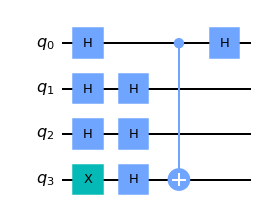

In [14]:
dj_circuit(3).draw(output="mpl")

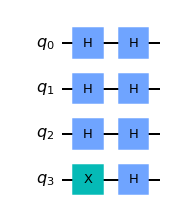

In [15]:
dj_circuit(3, balance=False).draw(output="mpl")

## 4. Simon 算法



判定一个函数是常数函数还是平衡函数时，根据上一小节的讨论，经典确定性算法需要调用 $O(2^n)$ 次函数，而 D-J 算法只需要调用一次。
但是，如果考虑概率随机算法的话存在经典概率算法只需要调用 2 次函数就能以固定概率成功判定其是常数函数还是平衡函数。

Simon 算法则是从概率算法的意义上，依然有 query 复杂度的指数加速。

其问题如下：

给定一个函数 $f: \{0, 1\}^n \rightarrow \{0, 1\}^n$，且该函数的映射是二对一的，存在非零比特串密钥 $s\in \{0, 1\}^n$，使得
$$\forall x, y \in \{0, 1\}^n, f(x)=f(y) ~\rm{iff}~ x\oplus y = s$$. 算法则是需要找到该比特串密钥。

Simon 算法的线路结构与 DJ 算法一致。

In [17]:
def oracle(c, s: str):
    n = c._nqubits // 2
    for i in range(n):
        c.cnot(i, i + n)
    for i, j in enumerate(s):
        if j == "1":
            for k, l in enumerate(s):
                if l == "1":
                    c.cnot(i, k + n)
            break
    return c


# check the oracle satisy simon algorithm promise

for init in itertools.product(*[[0, 1] for _ in range(3)]):
    c = tc.Circuit(6)
    for i, j in enumerate(init):
        if j == 1:
            c.x(i)
    print("input: ", init)
    out = oracle(c, "111").sample()[0]
    print("output: ", tuple([int(o) for o in out[3:]]))

input:  (0, 0, 0)
output:  (0, 0, 0)
input:  (0, 0, 1)
output:  (0, 0, 1)
input:  (0, 1, 0)
output:  (0, 1, 0)
input:  (0, 1, 1)
output:  (0, 1, 1)
input:  (1, 0, 0)
output:  (0, 1, 1)
input:  (1, 0, 1)
output:  (0, 1, 0)
input:  (1, 1, 0)
output:  (0, 0, 1)
input:  (1, 1, 1)
output:  (0, 0, 0)


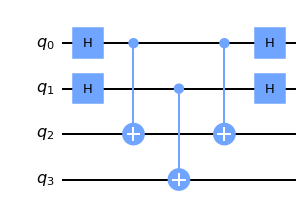

In [20]:
def simon_circuit(n, s: str):
    c = tc.Circuit(2 * n)
    for i in range(n):
        c.H(i)
    c = oracle(c, s)
    for i in range(n):
        c.H(i)
    return c


simon_circuit(2, "10").draw(output="mpl")

In [24]:
def simon_alg(n, s: str):
    c = simon_circuit(n, s)
    return c.sample()


simon_alg(2, "11")

(array([0., 0., 0., 1.], dtype=float32), 0.24999995529651642)

## 5. Grover 搜索 （Grover search）


&emsp;&emsp; 搜索问题一直处于计算机算法的核心。本节介绍一个重要的量子搜索框架：Grover Search。需要说明的是，Grover search 只是一个解决搜索问题的框架，需要根据具体的问题设计特定的模块算法。

&emsp;&emsp; **问题定义:** 考虑$N=2^n$个数（从0至$2^n-1$），里面有$M$个值满足$f(x)=1$，称为$f(x)$的解，对其余的$x$值，$f(x)=0$。找出所有的解(假设我们已经知道$M$的值)。

这是一个给定函数寻找解的问题，大量实际的问题可以约化到这种形式。一般情况下，最好的经典算法也要进行$O(N)$次$f(x)$的计算。但是我们将会看到，量子算法可以大大减少计算量。我们这里额外需要一个概念叫量子Oracle。Oracle 只是一个完成特定功能的量子电路（内部结构我们不是很关心），在这里，我们需要的Oracle满足
$$
|x\rangle|q\rangle \xmapsto{O} |x\rangle|q\oplus f(x)\rangle
$$
（注意与Deutch-Jozsa 算法中的$U_f$变换的对比）。$|q\rangle$所在的量子比特称为Oracle的辅助量子比特，如果我们将其制备于$\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$，那么就会有
$$
|x\rangle\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \xmapsto{O} (-1)^{f(x)}|x\rangle\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)
$$
由于Oracle作用前后辅助量子比特状态都不变，我们在讨论算法时可以先忽略它的存在，而认为
$$
|x\rangle\xmapsto{O}(-1)^{f(x)}|x\rangle。
$$

* > 例子(Oracle的电路)： 考虑一个计算空间$N=4$的函数$f(x)$，其中$f(0)=0,f(1)=0,f(2)=1,f(3)=0$，那么由Deutsch-Jozsa算法类似的电路，我们可以用$\rm Toffoli$和$X$门构造这个Oracle，如下图。这里$q_0$和$q_1$代表计算用的2个比特，$q_2$是辅助Oracle量子比特，初始制备在$1/\sqrt{2}(|0\rangle-|1\rangle)$态上。
<div align = center>
<img src="./img/simple_oracle.png" width="250" />
<figcaption align = "center"> f(x) 的Oracle电路</figcaption>
</div>

* > 区分“计算”和“识别”问题的解。“计算”问题的解和能够“识别”解决方案之间的区别；关键是可以做后者的时候不必做前者。一个简单的例子来说明这一点是质因数分解问题。假设我们得到了一个大数$m$，并告诉我们它是两个素数$p$ 和$q$的乘积。要计算出$p$，$q$很困难，但是给定$p$，$q$，我们却能很快识别他们的积是否是$m$。要确定$p$和$q$，在经典计算机上显而易见的方法是搜索从2 到 $m^{1/2}$的所有数字，以寻找两个质因数中较小的一个。也就是说，我们依次对$2$ 到 $m^{1/2}$ 范围内的每个数进行对$m$的试除，直到找到更小的素因数。 然后可以通过将$m$除以较小的素数来找到另一个素数因子。 显然，这种基于搜索的方法需要大约 $m^{1/2}$ 次试验才能在经典计算机上找到一个因子。而Grover Search正式要加速这种过程。


&emsp;&emsp; **算法过程：** 

&emsp;&emsp;我们假设$O$的构造已经给出，我们可以调用$O$。我们首先制备一个量子态$|\psi\rangle$处于所有$x$的均匀叠加：
$$
|\psi\rangle=\frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}|x\rangle。
$$
我们定义一下两个量子态：
$$
\begin{aligned}
|\alpha\rangle &= \frac{1}{\sqrt{N-M}}\sum_{x\notin S}|x\rangle，\\
|\beta\rangle &= \frac{1}{\sqrt{M}}\sum_{x \in S}|x\rangle
\end{aligned}
$$
$|\beta\rangle$代表所有解的均匀叠加态，$|\alpha\rangle$代表剩余的$x$的均匀叠加态。这两个态互相正交，见下图。

<div align = center>
<img src="./img/swing.png" width="300"  />
<figcaption align = "center"> Grover search的可视化</figcaption>
</div>

通过简单计算，我们有：
$$
|\psi\rangle=\sqrt{\frac{N-M}{N}}|\alpha\rangle+\sqrt{\frac{M}{N}}|\beta\rangle = \cos(\theta/2)|\alpha\rangle+\sin(\theta/2)|\beta\rangle。
$$
注意$|\alpha\rangle$， $|\beta\rangle$和$|\psi\rangle$ 在同一平面上，如上图。算法的目标是要让$|\psi\rangle$通过计算之后尽量逼近$|\beta\rangle$，然后对量子比特进行测量后得到的结果就会是$f(x)$的解。

我们作用Oracle $O$，就会发现
$$
|\psi_1\rangle=O|\psi\rangle = \cos(\theta/2)|\alpha\rangle-\sin(\theta/2)|\beta\rangle， 
$$
因为
$$
O|\alpha\rangle = \frac{1}{\sqrt{N-M}}\sum_{x\notin S}O|x\rangle = \frac{1}{\sqrt{N-M}}\sum_{x\notin S}|x\rangle=|\alpha\rangle,
$$
和
$$
O|\beta\rangle = \frac{1}{\sqrt{M}}\sum_{x \in S}O|x\rangle = \frac{1}{\sqrt{M}}\sum_{x \in S}(-1)|x\rangle=-|\beta\rangle。
$$
我们可以发现，$O$的作用是将$|\psi\rangle$对$|\alpha\rangle$（或$|\beta\rangle$，这里等价）所在轴进行反射。$O$在$\{|\alpha\rangle，|\beta\rangle\}$这组基下的表示为：
$$
O= \left(
  \begin{array}{cc}
    1 & 0  \\
    0 & -1 \\
  \end{array}
\right)
$$
然后我们考虑下面这个算子（具体电路构造之后会给出）
$$
2|\psi\rangle\langle\psi| - I，
$$
这个算子在$\{|\alpha\rangle，|\beta\rangle\}$这组基下的表示为
$$
2|\psi\rangle\langle\psi| - I= \left(
  \begin{array}{cc}
    \cos(\theta) & \sin(\theta)  \\
    \sin(\theta) & -\cos(\theta) \\
  \end{array}
\right)
$$
这正是将量子态对$|\psi\rangle$所在轴进行反射。
* > 关于翻转算符：我们以三维欧几里得空间为例来说明$2|\psi\rangle\langle\psi| - I$的翻转效果。考虑三维空间的两个单位向量$\vec{v}$和$\vec{a}$，并在$\vec{v}$和$\vec{a}$组成的平面中将$\vec{v}$对$\vec{a}$进行翻转。我们有$\vec{v}=\vec{v}_\perp+\vec{v}_{\|}$，其中$\vec{v}_\perp$，$\vec{v}_{\|}$分别对应于$\vec{v}$垂直和平行于$\vec{a}$的分量。那么我们就有$\vec{v}$的反射向量：
$$
\vec{v}_R = \vec{v}-2\vec{v}_{\perp}=2\vec{v}_{\|}-\vec{v}=2\vec{a}(\vec{a}^T \vec{v})-\vec{v}=2(\vec{a}\vec{a}^T-I)\cdot \vec{v}
$$
这里，$\vec{a}\vec{a}^T$可以看成是一个并矢量，其表示是一个矩阵，也就对应我们的外积（注意，这里考虑的是实空间）。将$\vec{a}$用$|\psi\rangle$替代，我们就得到对$|\psi\rangle$的反射算符$2|\psi\rangle\langle\psi| - I$。


这样，我们将$2|\psi\rangle\langle\psi| - I$作用于$|\psi_1\rangle$上，就有
$$
|\psi_2\rangle=(2|\psi\rangle\langle\psi| - I)|\psi_1\rangle=
\cos\left(\frac{3\theta}{2}\right)|\alpha\rangle+\sin\left(\frac{3\theta}{2}\right)|\beta\rangle，
$$
也就是说，经过两次反射之后，整体效果是$|\psi\rangle$朝$|\beta\rangle$方向旋转了$\theta$角度，如上图所示。$G$的实现如下图所示。

<div align = center>
<img src="./img/Grover_iteration.png" width="500"  />
<figcaption align = "center"> G 算子电路构造图</figcaption>
</div>

* > 例：$G$算符的量子电路实现：我们仍然使用之前的例子，考虑一个计算空间$N=4$的函数$f(x)$，其中$f(0)=0,f(1)=0,f(2)=1,f(3)=0$，那么整个$G$的电路图如下图所示：
<div align = center>
<img src="./img/Circuit_G.png" width="450" />
<figcaption align = "center"> f(x) 的G算子电路</figcaption>
</div>

我们也可以显式地定义两次翻转的算符$G$:
$$
G = (2|\psi\rangle\langle\psi| - I)O = \left(
  \begin{array}{cc}
    \cos(\theta) & -\sin(\theta)  \\
    \sin(\theta) & \cos(\theta) \\
  \end{array}
\right)，
$$
这也正是旋转$\theta$的矩阵（$\sin(\theta) = \frac{2\sqrt{M(N-M)}}{N}$）。可以验证，重复作用$G$算子$k$次，我们有
$$ 
G^k = \left(
  \begin{array}{cc}
    \cos(k\theta) & -\sin(k\theta)  \\
    \sin(k\theta) & \cos(k\theta) \\
  \end{array}
\right)
$$
这样，总共经过
$$
R = \left\lceil \frac{\arccos\sqrt{M/N}}{\theta}  \right\rceil \leq \lceil \frac{\pi}{4}\sqrt{N/M} \rceil \sim O(\sqrt{N/M})
$$
次$G$算子作用后，我们就能达到$|\beta\rangle$态，即找到$f(x)$的解。整个过程如下图所示。
<div align = center>
<img src="./img/Grover.png" width="500"  />
<figcaption align = "center"> Grover search的整体电路图</figcaption>
</div>



**算法过程总结：**
输入：
* 一个Oracle $O$ （及相应的实现电路）进行以下变换
$$
O|x\rangle|q\rangle = |x\rangle|q\oplus f(x)\rangle，
$$
其中对$x$的$2^n$种不同取值，除了$x_0$之外，$f(x) = 0$。

* $n+1$个量子比特处于$|0\rangle^{\otimes n}$。

输出：$x_0$
过程：
1. $|0\rangle^{\otimes n}|0\rangle$    
2. 经过$H^{\otimes (n+1) } X_{n}$ 之后得到
$$
\frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}|x\rangle\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)=|\psi\rangle\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)
$$
3. 重复$R$次Grover 算符$G=(2|\psi\rangle\langle\psi|-I)O$ （$R\sim \sqrt{2^n}$)，得到
$$
G^R\frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}|x\rangle\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)\approx|x_0\rangle\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)
$$
4. 以概率~1得到$x_0$

总调用量子门数量为$O\left(\sqrt{2^n}g_G(n)\right)$， $g_G(n)$为实现G电路所需要的量子门数量。与之对比，最好的经典算法需要的门数量为$O\left(2^n g_f(n)\right)$，$g_f$为计算$f$所需要的门的数量。当$g_G(n)\sim g_f(n)$时，Grover search也能指数地提升计算速度。但可惜的是，经过加速之后的算法仍然是指数复杂的。



* > 关于Grover search的进一步说明：我们从以上的推导可以发现，Grover Search 应用于搜索某个问题的解。在经典计算中，对某些问题，最好的方法也只能通过暴力尝试所有$O(N)$个输入并计算$f(x)$来找到解，而Grover search 可以将尝试的次数减少到$O(\sqrt{N})$。如果每一次经典的尝试和量子的尝试相差的时间不大的话，那么量子计算就会比经典计算快得多。值得注意的是，这种搜索与数据库的搜索并不一致。Grover search原则上也可以进行数据库搜索，但其相对于经典算法的优越性则要看数据存储的结构。